https://nixtla.mintlify.app/neuralforecast/examples/longhorizon_with_nhits.html

In [1]:
!pip install neuralforecast datasetsforecast


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78

In [2]:
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon
import matplotlib.pyplot as plt
from ray import tune
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.numpy import mae, mse


It return three Dataframes: Y_df contains the values for the target variables, X_df contains exogenous calendar features and S_df contains static features for each time-series (none for ETTm2). For this example we will only use Y_df.

In [3]:
### Change this to your own data to try the model ###

Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

### For this excercise we are going to take 20% of the DataSet ###

n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

100%|██████████| 314M/314M [00:14<00:00, 21.9MiB/s]


,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
57600,HULL,2016-07-01 00:00:00,0.040104
57601,HULL,2016-07-01 00:15:00,-0.214450
115200,LUFL,2016-07-01 00:00:00,0.695804
115201,LUFL,2016-07-01 00:15:00,0.434685
172800,LULL,2016-07-01 00:00:00,0.434430
172801,LULL,2016-07-01 00:15:00,0.428168
230400,MUFL,2016-07-01 00:00:00,-0.599211
230401,MUFL,2016-07-01 00:15:00,-0.658068


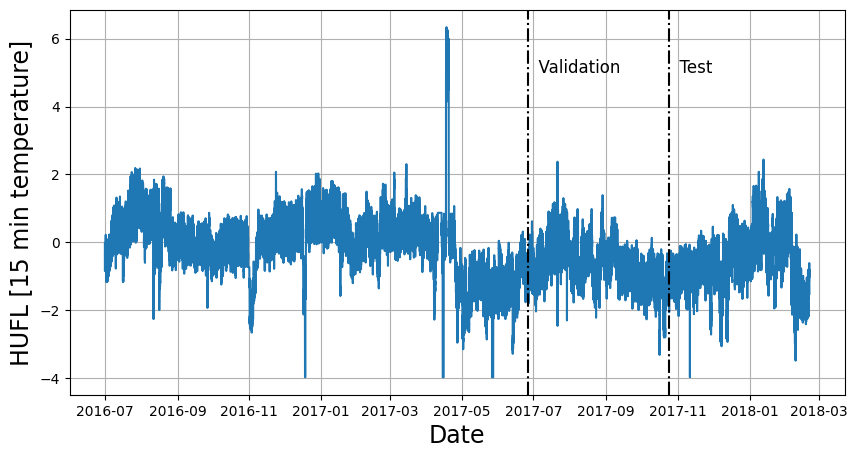

In [4]:
### We are going to plot the temperature of the transformer ###
### and marking the validation and train splits             ###

u_id = 'HUFL'
x_plot = pd.to_datetime(Y_df[Y_df.unique_id == u_id].ds)
y_plot = Y_df[Y_df.unique_id == u_id].y.values

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Date', fontsize=17)
plt.ylabel('HUFL [15 min temperature]', fontsize=17)

plt.axvline(x_val, color='black', linestyle='-.')
plt.axvline(x_test, color='black', linestyle='-.')
plt.text(x_val, 5, '  Validation', fontsize=12)
plt.text(x_test, 5, '  Test', fontsize=12)

plt.grid()


### Hyperparameter tuning

In [5]:
horizon = 96 # 24hrs = 4 * 15 min.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }


To instantiate AutoNHITS you need to define:

* **h**: forecasting horizon  
* **loss**: training loss. Use the DistributionLoss to produce probabilistic forecasts.
* **config**: hyperparameter search space. If None, the AutoNHITS class will use a pre-defined suggested hyperparameter space.
* **num_samples**: number of configurations explored.

In [6]:
models = [AutoNHITS(h = horizon,
                    config = nhits_config,
                    num_samples = 5)]

Fit the model by instantiating a NeuralForecast object with the following required parameters:

* **models**: a list of models.
* **freq**: a string indicating the frequency of the data. (See panda’s available frequencies.)

The cross_validation method allows you to simulate multiple historic forecasts, greatly simplifying pipelines by replacing for loops with fit and predict methods.

In [7]:
nf = NeuralForecast(models = models,
                    freq = '15min')

Y_hat_df = nf.cross_validation(df = Y_df, val_size = val_size,
                               test_size = test_size, n_windows = None)

2023-11-14 15:25:06,920	INFO worker.py:1673 -- Started a local Ray instance.
2023-11-14 15:25:09,037	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2023-11-14 15:25:09,052	INFO tune.py:595 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2023-11-14_15-25-04   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2023-11-14_15-25-04
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2023-11-14_15-25-04`


(_train_tune pid=1316) Seed set to 6
(_train_tune pid=1316) 2023-11-14 15:25:15.988661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=1316) 2023-11-14 15:25:15.988720: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=1316) 2023-11-14 15:25:15.988764: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=1316) 2023-11-14 15:25:16.001002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(_train_tune pid=1316) To enable the following

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.43it/s, v_num=0, train_loss_step=0.291, train_loss_epoch=0.263]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 26.36it/s, v_num=0, train_loss_step=0.241, train_loss_epoch=0.262, valid_loss=0.254]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s, v_num=0, train_loss_step=0.241, train_loss_epoch=0.249, valid_loss=0.249]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s, v_num=0, train_loss_step=0.249, train_loss_epoch=0.222, valid_loss=0.241]
Validation: |          | 0/? [00:00<?, ?it/s]

(_train_tune pid=1316) Seed set to 2


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s, v_num=0, train_loss_step=0.238, train_loss_epoch=0.273]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 28.20it/s, v_num=0, train_loss_step=0.235, train_loss_epoch=0.266, valid_loss=0.261]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 26.10it/s, v_num=0, train_loss_step=0.228, train_loss_epoch=0.218, valid_loss=0.249]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 26.59it/s, v_num=0, train_loss_step=0.216, train_loss_epoch=0.240, valid_loss=0.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:

(_train_tune pid=1316) Seed set to 2


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.42it/s, v_num=0, train_loss_step=0.250, train_loss_epoch=0.284]
(_train_tune pid=1316) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s, v_num=0, train_loss_step=0.242, train_loss_epoch=0.279, valid_loss=0.251]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s, v_num=0, train_loss_step=0.229, train_loss_epoch=0.218, valid_loss=0.259]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=1316) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 27.34it/s, v_num=0, train_loss_step=0.217, train_loss_epoch=0.240, valid_loss=0.252]
(_train_tune pid=1316) 
Validation: |          |

(_train_tune pid=1316) Seed set to 7


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.73it/s, v_num=0, train_loss_step=0.254, train_loss_epoch=0.263]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 26.16it/s, v_num=0, train_loss_step=0.237, train_loss_epoch=0.260, valid_loss=0.249]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 27.74it/s, v_num=0, train_loss_step=0.249, train_loss_epoch=0.256, valid_loss=0.241]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
(_train_tune pid=1316) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 26.20it/s, v_num=0, train_loss_step=0.236, train_loss_epoch=0.232, valid_loss=0.245]
V

(_train_tune pid=1316) Seed set to 2


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.38it/s, v_num=0, train_loss_step=0.230, train_loss_epoch=0.264]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 26.50it/s, v_num=0, train_loss_step=0.224, train_loss_epoch=0.258, valid_loss=0.246]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s, v_num=0, train_loss_step=0.220, train_loss_epoch=0.214, valid_loss=0.251]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=1316) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=1316) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s, v_num=0, train_loss_step=0.213, train_loss_epoch=0.236, valid_loss=0.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  

INFO:lightning_fabric.utilities.seed:Seed set to 6


(_train_tune pid=1316) 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.181, valid_loss=0.238]



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
nf.models[0].results.get_best_result().config
# {'learning_rate': 0.001,
#  'max_steps': 1000,
#  'input_size': 480,
#  'batch_size': 7,
#  'windows_batch_size': 256,
#  'n_pool_kernel_size': [2, 2, 2],
#  'n_freq_downsample': [168, 24, 1],
#  'activation': 'ReLU',
#  'n_blocks': [1, 1, 1],
#  'mlp_units': [[512, 512], [512, 512], [512, 512]],
#  'interpolation_mode': 'linear',
#  'val_check_steps': 100,
#  'random_seed': 6,
#  'h': 96,
#  'loss': MAE(),
#  'valid_loss': MAE()}

{'learning_rate': 0.001,
 'max_steps': 1000,
 'input_size': 480,
 'batch_size': 7,
 'windows_batch_size': 256,
 'n_pool_kernel_size': [2, 2, 2],
 'n_freq_downsample': [168, 24, 1],
 'activation': 'ReLU',
 'n_blocks': [1, 1, 1],
 'mlp_units': [[512, 512], [512, 512], [512, 512]],
 'interpolation_mode': 'linear',
 'val_check_steps': 100,
 'random_seed': 6,
 'h': 96,
 'loss': MAE(),
 'valid_loss': MAE()}

In [9]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoNHITS'].values

n_series = len(Y_df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)


Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (7, 11425, 96)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (7, 11425, 96)


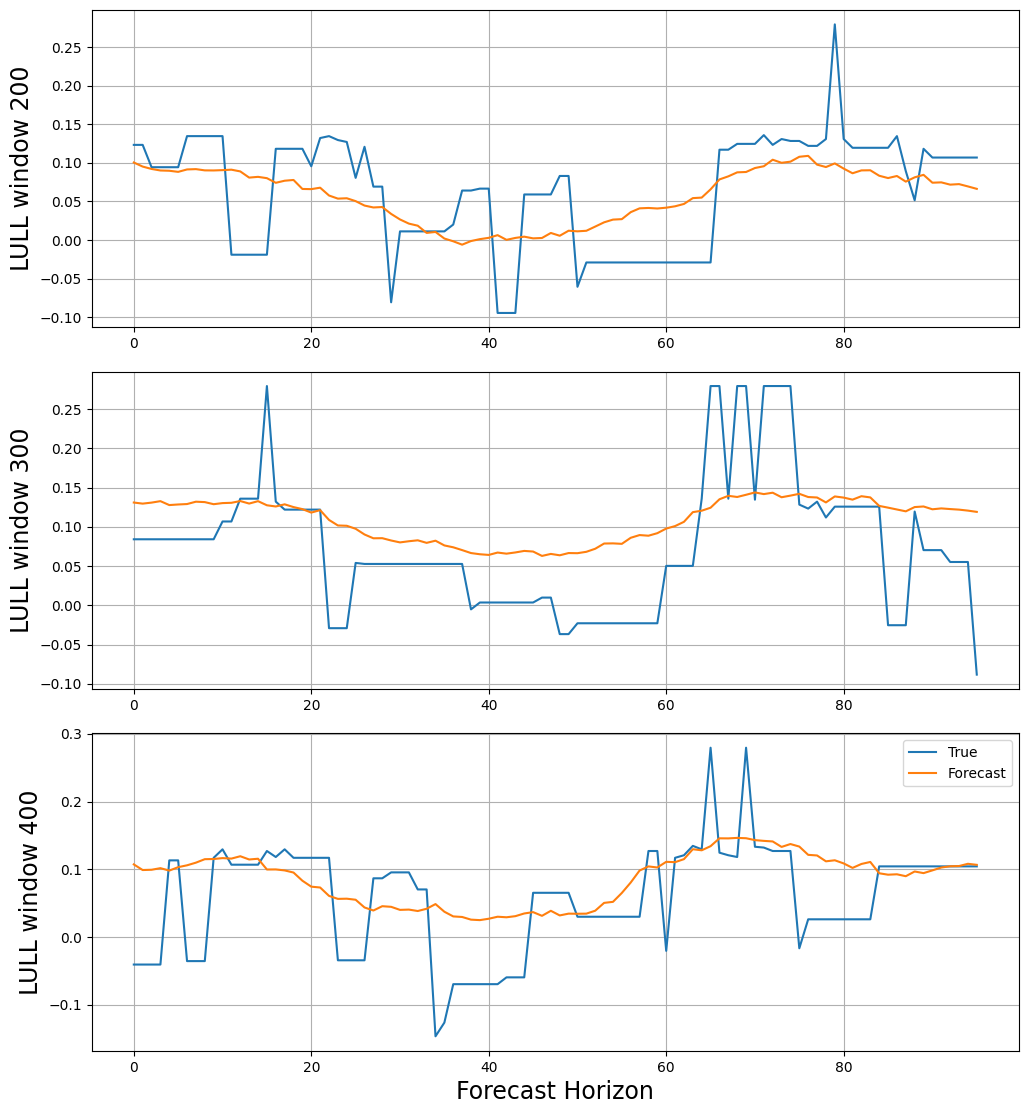

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

series = ['HUFL','HULL','LUFL','LULL','MUFL','MULL','OT']
series_idx = 3

for idx, w_idx in enumerate([200, 300, 400]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(series[series_idx]+f' window {w_idx}',
                      fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()


In [11]:
print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))


MAE:  0.2586876380081865
MSE:  0.18985573174063078
